*Last Modified*: March 3rd, 2023. [OI]

## CHAMP (CHallenging Minisatellite Payload) thermospheric neutral density data derived via STAR (Space Three-axis Accelerometer for Research) accelerometer data. 
Downloaded from http://thermosphere.tudelft.nl/

##### References
[1] Masutti, D., March, G., Ridley, A. J., and Thoemel, J., “Effect of the solar activity variation on the Global Ionosphere Thermosphere Model (GITM)”, *Annales Geophysicae*, vol. 34, no. 9, pp. 725–736, 2016. doi:10.5194/angeo-34-725-2016.

##### Time period
The specific simulation windows have been selected in periods of low geomagnetic activity ($A_{p}$ < 30) in order to avoid any geomagnetic storm that could interfere with the study.

* Solar *Maximum* Cycle 23: 18/12/2001 $\to$ F10.7 $\approx 233$
* *Descending* Phase Cycle 23: 10/04/2004 $\to$  F10.7 $\approx 100$
* Solar *Minimum* Cycle 23: 24/10/2008 $\to$ F10.7 $\approx 66$

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
from pandas import read_csv
import pandas as pd
import datetime as df
import astropy
from pymsis import msis
from astropy.coordinates import SkyCoord
from datetime import datetime, timedelta
from astropy.constants import R_earth
import astropy.units as u
from astropy import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 11}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [11]:
data = read_csv("data_champ/CH_DNS_ACC_2008_10_v02.txt", sep='\s+', on_bad_lines='skip')
data

,date,time,GPS/UTC,alt,lon,lat,lst,arglat,rho_x,rho_mean,Colu,Colu.1
0,2008-10-01,00:00:00.000,GPS,326044.167,49.144013,10.553110,3.444,10.472099,1.662481e-12,1.868571e-12,0.0,0.0
1,2008-10-01,00:00:10.000,GPS,326016.699,49.135305,11.215545,3.446,11.131414,1.665051e-12,1.868629e-12,0.0,0.0
2,2008-10-01,00:00:20.000,GPS,325993.920,49.126748,11.877959,3.448,11.790748,1.669296e-12,1.868687e-12,0.0,0.0
3,2008-10-01,00:00:30.000,GPS,325975.799,49.118352,12.540349,3.451,12.450101,1.678171e-12,1.868745e-12,0.0,0.0
4,2008-10-01,00:00:40.000,GPS,325962.304,49.110127,13.202712,3.453,13.109473,1.706243e-12,1.868803e-12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
262856,2008-10-31,23:59:10.000,GPS,333479.106,170.030833,79.928660,11.591,99.715948,2.400383e-12,2.682148e-12,0.0,0.0
262857,2008-10-31,23:59:20.000,GPS,333425.800,170.960426,79.295574,11.655,100.376738,2.390056e-12,2.682253e-12,0.0,0.0
262858,2008-10-31,23:59:30.000,GPS,333369.270,171.782553,78.659785,11.713,101.037525,2.336933e-12,2.682357e-12,0.0,0.0
262859,2008-10-31,23:59:40.000,GPS,333309.556,172.513970,78.021714,11.765,101.698311,2.315419e-12,2.682461e-12,0.0,0.0


In [12]:
data_timestamps = []

In [13]:
# save all timestamps in UTC. 
for ii in range(np.shape(data)[0]):
    # timestamp in GPS from chart. 
    GPS_timestamp = time.Time(str(data["date"][ii] + "T" + data["time"][ii])).gps
    GPS_time = time.Time(GPS_timestamp, format="gps")
    # convert to UTC [which is approx 12 seconds ahead].
    UTC_time = time.Time(GPS_time, format='iso',  scale='utc').value
    # add UTC timestamp to a list
    data_timestamps.append(pd.Timestamp(year=int(UTC_time[:4]), 
                                    month=int(UTC_time[5:7]), 
                                    day=int(UTC_time[8:10]),
                                    hour=int(UTC_time[11:13]), 
                                    minute=int(UTC_time[14:16]), 
                                    second=int(UTC_time[17:19]), 
                                    microsecond=int(UTC_time[20:])))

In [14]:
# coordinate transformation from geodetic to geocenteric
coords_geodetic = astropy.coordinates.EarthLocation.from_geodetic(lon=data["lon"]*u.deg, 
                                                         lat=data["lat"]*u.deg, 
                                                         height=data["alt"]*u.m, 
                                                         ellipsoid="GRS80")

x, y, z = coords_geodetic.geocentric

In [15]:
# descibe in spherical coordinates
coords_geocentric = astropy.coordinates.cartesian_to_spherical(x=x, y=y,z=z)
coords_geocentric

(<Distance [6703469.43674745, 6703350.96292721, 6703231.92965602, ...,
            6690954.85825366, 6690990.11211103, 6691027.40701409] m>,
 <Latitude [0.18303957, 0.1945328 , 0.20602632, ..., 1.37163795, 1.36043607,
            1.34920076] rad>,
 <Longitude [0.85772483, 0.85757285, 0.8574235 , ..., 2.99817114,
             3.01093678, 3.02235498] rad>)

### Considered time period 2 days of "spin off" and 1 day of simulation

In [16]:
max_timestamp = 155000
min_timestamp = 129500

In [17]:
print(data_timestamps[min_timestamp])
print(data_timestamps[max_timestamp])

2008-10-16 13:33:10
2008-10-19 12:23:10


### Intersection with San Diego

In [18]:
san_diego_lon, san_diego_lat = -117.1611, 32.7157

In [19]:
index_lon = np.where(np.abs(coords_geocentric[2].to(u.deg)[min_timestamp:max_timestamp]-180*u.deg - san_diego_lon*u.deg) < 10*u.deg)

In [20]:
index_lat = np.where(np.abs(coords_geocentric[1].to(u.deg)[min_timestamp:max_timestamp] - san_diego_lat*u.deg) < 5*u.deg)

In [21]:
index_intersect = np.intersect1d(index_lon, index_lat)

### Plot CHAMP meassurements

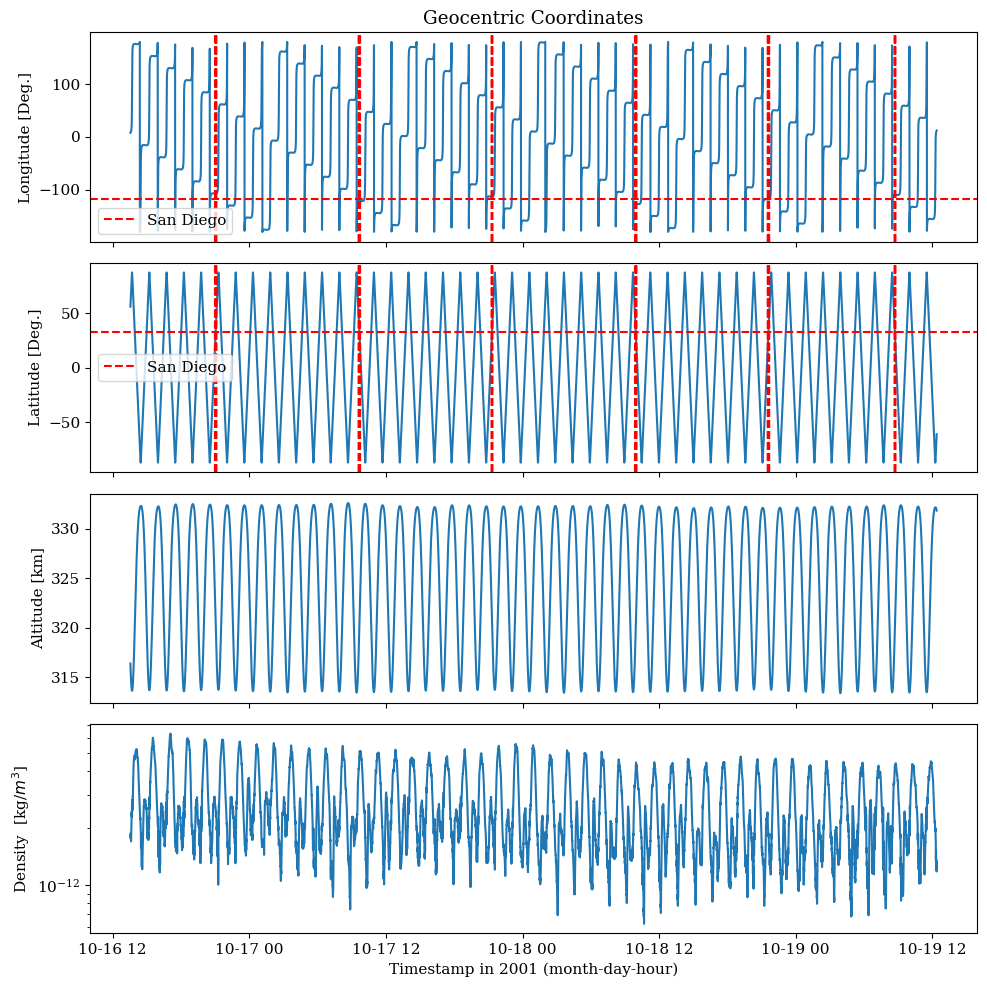

In [23]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 10))
ax[0].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[2].to(u.deg)[min_timestamp :max_timestamp]-180*u.deg)
ax[0].axhline(san_diego_lon, c="r", ls="--", label="San Diego")
ax[0].set_ylabel("Longitude [Deg.]")
ax[1].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[1].to(u.deg)[min_timestamp :max_timestamp])
ax[1].set_ylabel("Latitude [Deg.]")
ax[1].axhline(san_diego_lat, c="r", ls="--", label="San Diego")
ax[2].plot(data_timestamps[min_timestamp :max_timestamp], (coords_geocentric[0] - R_earth).to(u.km)[min_timestamp :max_timestamp])
ax[2].set_ylabel("Altitude [km]")
ax[3].plot(data_timestamps[min_timestamp :max_timestamp], data["rho_x"][min_timestamp :max_timestamp])
ax[3].set_ylabel(r"Density  [kg/$m^3$]")
ax[0].set_title("Geocentric Coordinates")
ax[3].set_xlabel("Timestamp in 2001 (month-day-hour)")

for ii in index_intersect:
    ax[0].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[1].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[3].set_yscale("log")
plt.tight_layout()
plt.savefig("figs/CHAMP_location_and_observations_2008.png", dpi=600)

## Read in F10.7

In [24]:
f10p7_msis, f10p7a_msis, ap_msis = msis.get_f107_ap(dates=data_timestamps[min_timestamp:max_timestamp])

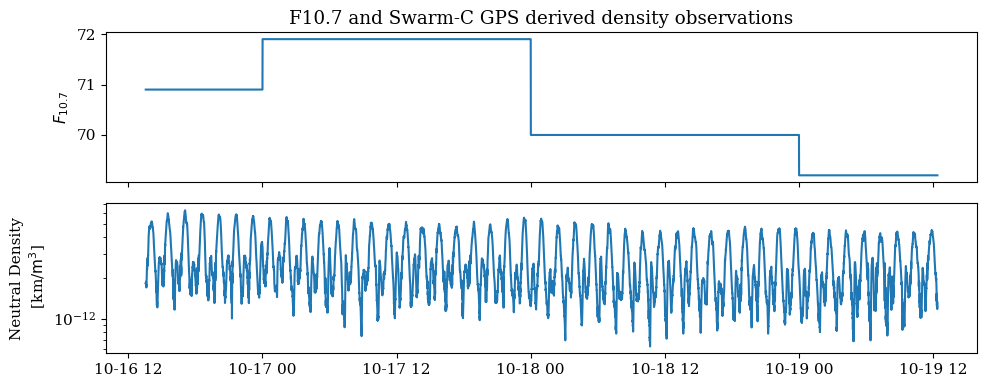

In [26]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
ax[0].plot(data_timestamps[min_timestamp:max_timestamp], f10p7_msis, label="F10.7")
ax[1].plot(data_timestamps[min_timestamp:max_timestamp], data["rho_x"][min_timestamp:max_timestamp])
ax[1].set_yscale("log")
ax[0].set_ylabel("$F_{10.7}$")
ax[0].set_title("F10.7 and Swarm-C GPS derived density observations")
#ax[0].legend()
_ = ax[1].set_ylabel("Neutral Density\n [km/$\mathrm{m}^3$]")
plt.tight_layout()
plt.savefig("figs/swarm_meassurements_and_f10.7_2008.png", dpi=600)

## Read in 1D-GITM Results